# Taller3_GetialCely - Predicción promedio del valor de acciones del mercado con redes LSTM y GRU

In [1]:
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np
import os

# Load Data

In [2]:
import os
fname = os.path.join("acer.us.txt")

with open(fname) as f:
    data = f.read()

# This outputs a count of 420,551 lines of data
# (each line is a timestep: a record of a date and 14 weather-related values)
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header) #Prints data headers
print(len(lines))

['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
3126


# Transform Data

In [3]:
average = np.zeros((len(lines)- 1,))
raw_data = np.zeros((len(lines) -1, 5))
for i, line in enumerate(lines):
    values = line.split(",")[1:5] # Eliminamos "Date" y "OpenInt" debido a que no son necesarios. "OpenInt" siempre es 0.
    if len(values) == 0:
        continue
    values = [float(x) for x in values]
    values.append((values[1] + values[2]) / 2) # We add the average of High and Low to the end of the values list.
    average[i] = values[-1] # We store ([High + Low] /2) in the “average” array.
    raw_data[i, :] = values[:] # We store all columns (including the average) in the “raw_data” array.


# Also check for zeros that might skew the model
if np.count_nonzero(average) < len(average):
    print("Warning: Dataset contains zeros which might affect model performance")

# Grafica Valor Promedio

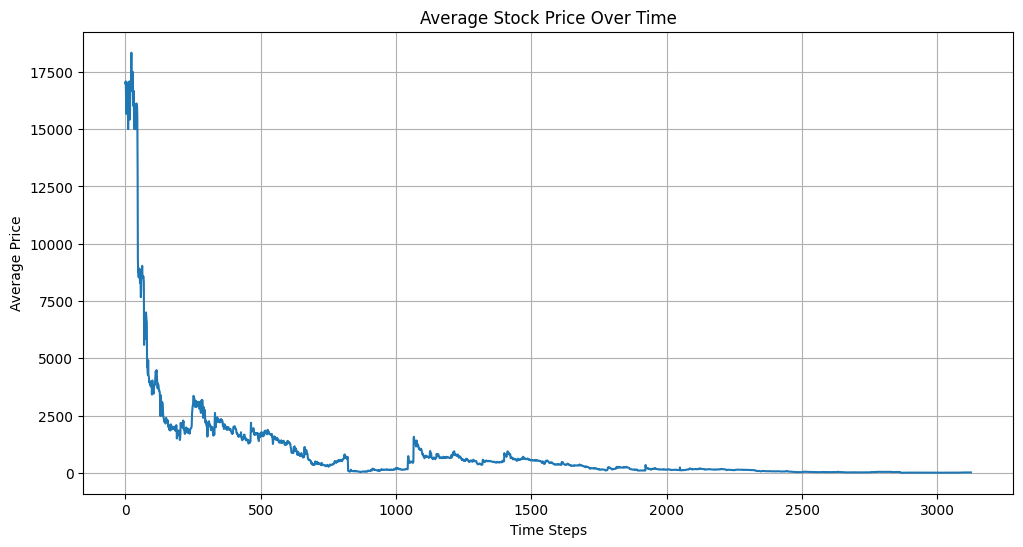

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(average)), average)
plt.title('Average Stock Price Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Average Price')
plt.grid(True)
plt.show()

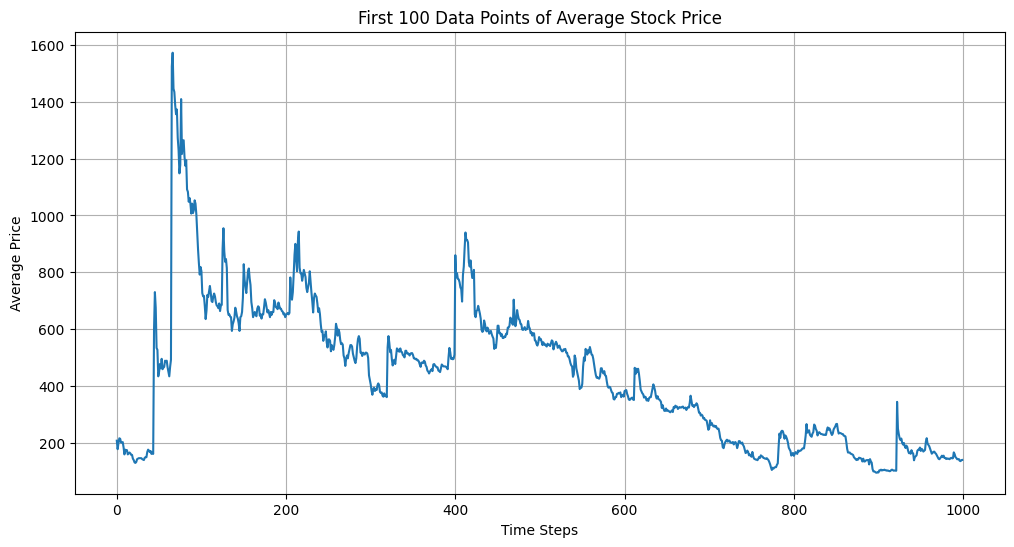

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(range(1000), average[1000:2000])
plt.title('First 100 Data Points of Average Stock Price')
plt.xlabel('Time Steps')
plt.ylabel('Average Price')
plt.grid(True)
plt.show()

# Tamaño de cada conjunto de datos

In [6]:
num_train_samples = int(0.7 * len(raw_data))
num_val_samples = int(0.15 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 2187
num_val_samples: 468
num_test_samples: 470


# Normalizacion de Datos

In [7]:
# Normalizar todas las columnas numéricas
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [8]:
average = raw_data[:, -1]

# Division de Datos: entrenamiento, validación y prueba

In [9]:
sampling_rate = 1
sequence_length = 7
delay = sampling_rate * (sequence_length + 1 - 1)
batch_size = 32


train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=average[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=average[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=average[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples + delay)

In [10]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (32, 7, 5)
targets shape: (32,)


# MODEL PARAMS

In [11]:
neurons = 32
num_epochs = 30
batch_size = 32
recurrent_dropout = 0.2

# LSTM MODEL

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(neurons,
                recurrent_dropout=recurrent_dropout,
                )(inputs) 
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

callbacks = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
]

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    callbacks=callbacks,
    batch_size=batch_size,
)

test_results = model.evaluate(test_dataset)
print(f"Test MSE: {test_results[0]:.4f}")
print(f"Test MAE: {test_results[1]:.4f}")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 7, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,897 (19.13 KB)

 Trainable params: 4,897 (19.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.4674 - mae: 0.2356 - val_loss: 0.0034 - val_mae: 0.0581
Epoch 2/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0856 - mae: 0.0806 - val_loss: 0.0019 - val_mae: 0.0430
Epoch 3/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0245 - mae: 0.0572 - val_loss: 0.0013 - val_mae: 0.0356
Epoch 4/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0130 - mae: 0.0465 - val_loss: 1.6105e-05 - val_mae: 0.0030
Epoch 5/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0144 - mae: 0.0454 - val_loss: 1.4562e-05 - val_mae: 0.0034
Epoch 6/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0087 - mae: 0.0362 - val_loss: 3.8742e-05 - val_mae: 0.0055
Epoch 7/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0064 - mae: 0.0333 - val_loss: 2.0218e-05 - val_mae: 0.0034
Epoch 8/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0079 - mae: 0.0346 - val_loss: 1.5107e-05 - val_mae: 0.0034
Epoch 9/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - 

## Curva de perdida vs iteraciones (epochs)

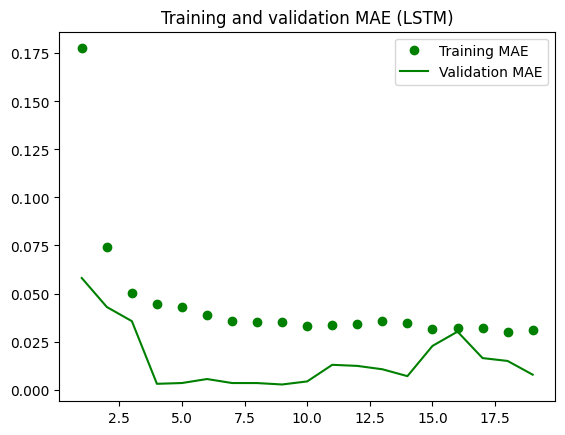

In [13]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "go", label="Training MAE")
plt.plot(epochs, val_loss, "g", label="Validation MAE")
plt.title("Training and validation MAE (LSTM)")
plt.legend()
plt.show()

## Predicciones vs Valor verdadero

In [14]:
# Predict using the trained model
predictions = model.predict(test_dataset)
predictions = predictions.flatten()  # Flatten to 1D if needed
predictions = predictions * std[-1] + mean[-1]# Rescale predictions

# Extract true values for plotting (optional: flatten to 1D if needed)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_true = y_true.flatten()  # Flatten to 1D if needed
y_true = y_true * std[-1] + mean[-1]  # Rescale true values

print("Predictions shape:", predictions.shape)
print("True values shape:", y_true.shape)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predictions shape: (450,)
True values shape: (450,)


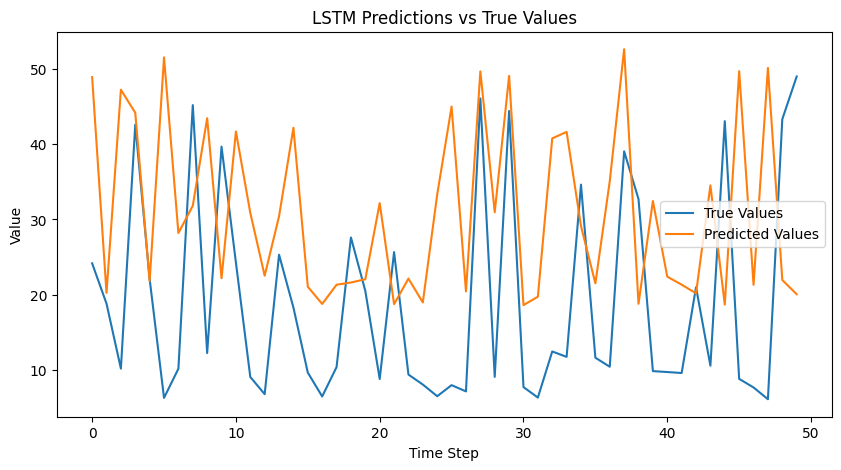

In [15]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(y_true[400:450], label='True Values')
plt.plot(predictions[400:450], label='Predicted Values')
plt.title('LSTM Predictions vs True Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

# GRU MODEL

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(neurons,
                recurrent_dropout=recurrent_dropout,
                )(inputs) 
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()


callbacks = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
]

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    callbacks=callbacks,
    batch_size=batch_size,
)

test_results = model.evaluate(test_dataset)
print(f"Test MSE: {test_results[0]:.4f}")
print(f"Test MAE: {test_results[1]:.4f}")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 7, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 32)             │         3,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,777 (14.75 KB)

 Trainable params: 3,777 (14.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.6648 - mae: 0.3226 - val_loss: 0.0033 - val_mae: 0.0578
Epoch 2/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0702 - mae: 0.0819 - val_loss: 4.5020e-04 - val_mae: 0.0211
Epoch 3/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0216 - mae: 0.0472 - val_loss: 5.1813e-04 - val_mae: 0.0226
Epoch 4/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0139 - mae: 0.0475 - val_loss: 3.3008e-04 - val_mae: 0.0180
Epoch 5/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0089 - mae: 0.0394 - val_loss: 2.6682e-04 - val_mae: 0.0162
Epoch 6/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0081 - mae: 0.0379 - val_loss: 2.9922e-04 - val_mae: 0.0172
Epoch 7/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0065 - mae: 0.0335 - val_loss: 4.2027e-04 - val_mae: 0.0204
Epoch 8/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0079 - mae: 0.0360 - val_loss: 3.6227e-04 - val_mae: 0.0189
Epoch 9/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms

## curva de perdida vs iteraciones

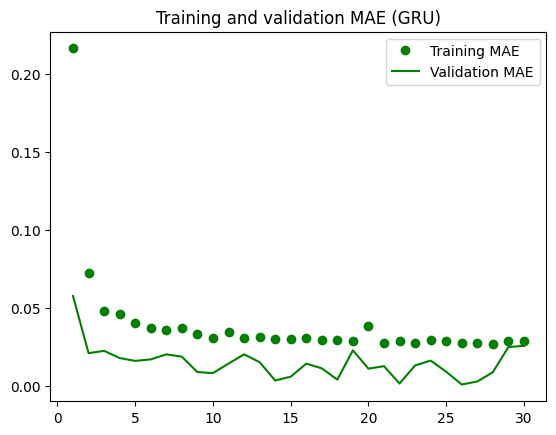

In [17]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "go", label="Training MAE")
plt.plot(epochs, val_loss, "g", label="Validation MAE")
plt.title("Training and validation MAE (GRU)")
plt.legend()
plt.show()

## Predicciones vs valor verdadero

In [18]:
# Predict using the trained model
predictions = model.predict(test_dataset)
predictions = predictions.flatten()  # Flatten to 1D if needed
predictions = predictions * std[-1] + mean[-1]# Rescale predictions

# Extract true values for plotting (optional: flatten to 1D if needed)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_true = y_true.flatten()  # Flatten to 1D if needed
y_true = y_true * std[-1] + mean[-1]  # Rescale true values

print("Predictions shape:", predictions.shape)
print("True values shape:", y_true.shape)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predictions shape: (450,)
True values shape: (450,)


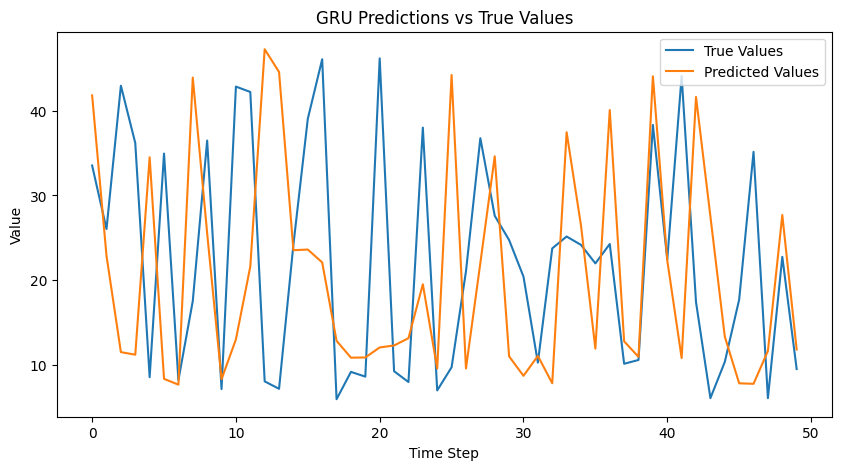

In [19]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(y_true[400:450], label='True Values')
plt.plot(predictions[400:450], label='Predicted Values')
plt.title('GRU Predictions vs True Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()